## DIAGNOSTIC PLOTS

TODO: Include 'file_tcva' in the Kepert netcdf cases.

TODO: Update the 00 LP KPP files!!!

TODO: Update the SAR repo!!!!

TODO: Update the filters!!!

In [1]:
# General
import glob
import re
import os.path
# import warnings
# warnings.filterwarnings('ignore')
from tqdm.notebook import tqdm
import copy

# Arrays & Displays
import xarray as xr
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from matplotlib.gridspec import GridSpec
import matplotlib.cm as cm
from matplotlib.lines import Line2D
from matplotlib.patches import Patch
import pandas as pd

# Data treatment
from datetime import datetime
from scipy.optimize import curve_fit
from scipy.interpolate import griddata
from scipy.optimize import minimize

# Default parameters
mpl.rcParams.update({'font.size': 18})
mpl.rcParams['figure.figsize'] = (15, 10)
mpl.rcParams['axes.facecolor'] = 'white'
mpl.rcParams['figure.facecolor'] = 'white'

In [2]:
# Paths & Params
PTHS = {
    'dsg_pth':     '/home/arthur/data/tropical_cyclones/SAR/parametric_dataset/dsg.nc',
    'sar_dir':     '/home/arthur/data/tropical_cyclones/SAR/S1_RS2_RCM/sar_files/',
    'sav_dir':     '/home/arthur/results/TCsLifeMonitFromObs/winddirection/PRJCT_TCBL/03_DIAGNOSE_PLOTS/',
    'sct_dir':     '/home/arthur/data/tropical_cyclones/scatterometer/hy-2/',
    # 'K01_PRM_dir': '/home/arthur/results/TCsLifeMonitFromObs/winddirection/PRJCT_TCBL/00_LP_KPP_K01/cases/',
    'K01_PRM_dir': '/home/arthur/results/TCsLifeMonitFromObs/winddirection/PRJCT_TCBL/00_LP_KPP_K01/new/cases/', ### OLD
    'K01_FIT_dir': '/home/arthur/results/TCsLifeMonitFromObs/winddirection/PRJCT_TCBL/00_FIT_K01/cases/',
    'K01_wIA_dir': '/home/arthur/results/TCsLifeMonitFromObs/winddirection/PRJCT_TCBL/00_FIT_K01_wINFLOW_ANGLE/cases/',
    'K25_PRM_dir': '/home/arthur/results/TCsLifeMonitFromObs/winddirection/PRJCT_TCBL/00_LP_KPP_K25_C1C2FIT/cases/',
    'K25_FIT_dir': '/home/arthur/results/TCsLifeMonitFromObs/winddirection/PRJCT_TCBL/00_FIT_K25/cases/',
    'K25_wIA_dir': '/home/arthur/results/TCsLifeMonitFromObs/winddirection/PRJCT_TCBL/00_FIT_K25_wINFLOW_ANGLE/cases/',
}

PRMS = {
    'sav_fgs': False,
}

# Open data
dsg = xr.open_dataset(PTHS['dsg_pth'])

# Fetch all PRM files
list_of_PRM_paths = glob.glob(PTHS['K01_PRM_dir'] + '*.nc')

In [3]:
# ### OLD

# # FILTERS
# cond = (
#     (dsg.center_quality_flag < 2) & 
#     (dsg.percent_outside < 50) & 
#     (dsg.percent_rmx_inside == 1) &
#     (abs(dsg.lat) < 30) & 
#     (dsg.rmx < 100000) & 
#     (dsg.vmx > 20)
# )
# dsg_filtered    = dsg.where(cond, drop=True)
# print(len(dsg_filtered.time))

In [4]:
# FILTERS
cond = (
    # (dsg.lat > 0) &             # Northern hemisphere; Remove this filter?
    (dsg.dist2coast  > dsg.r34) & # Distance to coast
    (dsg.percent_outside < 10)  & # Sufficient SAR coverage
    (dsg.vmx > 20)    
)
dsg_filtered    = dsg.where(cond, drop=True)
print(len(dsg_filtered.time))

591


In [5]:
def coriolis(lat):
    '''Latitude must be in degrees.'''
    Omega = 7.2921e-5                             # Earth rotation vector
    fcor  = 2 * Omega * np.sin(lat * np.pi / 180) # Coriolis parameter assuming it's constant 
    return fcor

def holland_profile(r, lat, B, Vmin, Rmax, Vmax):
    '''We assume that rho is constant and equals 1.15 kg.m-3'''
    fcor   = abs(coriolis(lat))
    rho    = 1.15
    r      = r.astype(float) + 0.001           # To avoid dividing by zero
    r_star = (Rmax / r) ** B
    V      = r * 0.
    V      = Vmin + np.sqrt( ((Vmax - Vmin) ** 2) * r_star * np.exp(1 - r_star) + (r * fcor / 2) ** 2) - (r * fcor / 2)
    return V

### 0) Fitting diagnostic and datasets filtering

The retained filters are:

In [7]:
# dk01 = dkg01.where(
#     # (dkg01.lat > 0) &                           # Northern hemisphere; Remove this filter?
#     (dkg01.dist2coast  > dkg01.r34)             & # Distance to coast
#     (dkg01.percent_outside < 10)                & # Sufficient SAR coverage
#     (dkg01.vmx > 20)                            & # Test
#     (dkg01.C_K01 != 0.0001)                     & # Reached the lower bound
#     (dkg01.C_K01 != 0.1)                        &  # Reached the upper bound
#     (dkg01.asym_avg_err  <= 3)                     # Asymmetry is fitted
#     # (~xr.where(dkg01.non_C1 == 0, False, True))  # Ensure that I > V/r
# )

# abs(dk01.C_sqrtK_K01 - dk012.C_sqrtK_K01) > 1e-5

With the subtility that dkg01.asym_avg_err <= 3 for K01 and dkg.asym_avg_err  <= 2 for K25 (explainable because the K01 asymmetries are less consistent with SAR than the K25 ones). Also, the non-C1 filter can be a posteriori highlighted on the plots. 

Lastly, we have to include the additional filter: abs(dk01.C_sqrtK_K01 - dk012.C_sqrtK_K01) > 1e-5 and same for K25, to make sure that I don't have any fitting issue (where dk01 is with fixed_K = 50 and dk012 is with fixed_K = 100).

#### a) K01_FIT

In [8]:
p     = '/home/arthur/results/TCsLifeMonitFromObs/winddirection/PRJCT_TCBL/00_FIT_K01/dsg_K01_withKsetto50.nc'
dkg01 = xr.open_dataset(p)
dk01  = dkg01.where(
    # (dkg01.lat > 0) &                           # Northern hemisphere; Remove this filter?
    (dkg01.dist2coast  > dkg01.r34)             & # Distance to coast
    (dkg01.percent_outside < 10)                & # Sufficient SAR coverage
    (dkg01.vmx > 20)                            & # Test
    (dkg01.C_K01 != 0.0001)                     & # Reached the lower bound
    (dkg01.C_K01 != 0.1)                        & # Reached the upper bound
    (dkg01.asym_avg_err  <= 3)                    # Asymmetry is fitted
    # (~xr.where(dkg01.non_C1 == 0, False, True)) # Ensure that I > V/r
    
    # ((dkg01.max_asym_K01 > 1.1) | (dkg01.max_asym_sar < 2)) # Test
    # (dkg01.phase_avg_err <= 45)                 &           # Test
    # ((dkg01.storm_speed_ibt / dkg01.vws_pmd) > 1)           # Test: Ratio storm_speed / wind_shead
)
print(len(dkg01.time))
print(len(dk01.dropna(dim='time').time))
# NB: Imposing a filter on c1 or c2 doesn't seem very useful.
# NB: Imposing a filter on the asymmetry error or max_asym difference is not very useful (may filter 3 bad cases but also removes one good case).
# The non-C1 filter removes some "good" cases. Maybe just encircle the non-C1 cases? 

640
108


In [9]:
p                   = '/home/arthur/results/TCsLifeMonitFromObs/winddirection/PRJCT_TCBL/00_FIT_K01/dsg_K01_withKsetto100.nc'
dkg01_withKsetto100 = xr.open_dataset(p)
dk01_withKsetto100  = dkg01_withKsetto100.where(
    # (dkg01.lat > 0) &                           # Northern hemisphere; Remove this filter?
    (dkg01_withKsetto100.dist2coast  > dkg01_withKsetto100.r34)             & # Distance to coast
    (dkg01_withKsetto100.percent_outside < 10)                              & # Sufficient SAR coverage
    (dkg01_withKsetto100.vmx > 20)                                          & # Test
    (dkg01_withKsetto100.C_K01 != 0.0001)                                   & # Reached the lower bound
    (dkg01_withKsetto100.C_K01 != 0.1)                                      & # Reached the upper bound
    (dkg01_withKsetto100.asym_avg_err  <= 3)                                  # Asymmetry is fitted
    # (~xr.where(dkg01_withKsetto100.non_C1 == 0, False, True))               # Ensure that I > V/r
    
    # ((dkg01_withKsetto100.max_asym_K01 > 1.1) | (dkg01_withKsetto100.max_asym_sar <2)) # Test
    # (dkg01_withKsetto100.phase_avg_err <= 45)                 &                        # Test
    # ((dkg01_withKsetto100.storm_speed_ibt / dkg01_withKsetto100.vws_pmd) > 1)          # Test: Ratio storm_speed / wind_shead
)
print(len(dkg01_withKsetto100.time))
print(len(dkg01_withKsetto100.dropna(dim='time').time))
# NB: Imposing a filter on c1 or c2 doesn't seem very useful.
# NB: Imposing a filter on the asymmetry error or max_asym difference is not very useful (may filter 3 bad cases but also removes one good case).
# The non-C1 filter removes some "good" cases. Maybe just encircle the non-C1 cases? 

640
210


In [10]:
p                   = '/home/arthur/results/TCsLifeMonitFromObs/winddirection/PRJCT_TCBL/00_FIT_K01/dsg_K01_withKsetto10.nc'
dkg01_withKsetto10 = xr.open_dataset(p)
dk01_withKsetto10  = dkg01_withKsetto10.where(
    # (dkg01.lat > 0) &                           # Northern hemisphere; Remove this filter?
    (dkg01_withKsetto10.dist2coast  > dkg01_withKsetto10.r34)             & # Distance to coast
    (dkg01_withKsetto10.percent_outside < 10)                              & # Sufficient SAR coverage
    (dkg01_withKsetto10.vmx > 20)                                          & # Test
    (dkg01_withKsetto10.C_K01 != 0.0001)                                   & # Reached the lower bound
    (dkg01_withKsetto10.C_K01 != 0.1)                                      & # Reached the upper bound
    (dkg01_withKsetto10.asym_avg_err  <= 3)                                  # Asymmetry is fitted
    # (~xr.where(dkg01_withKsetto10.non_C1 == 0, False, True))               # Ensure that I > V/r
    
    # ((dkg01_withKsetto10.max_asym_K01 > 1.1) | (dkg01_withKsetto10.max_asym_sar <2)) # Test
    # (dkg01_withKsetto10.phase_avg_err <= 45)                 &                        # Test
    # ((dkg01_withKsetto10.storm_speed_ibt / dkg01_withKsetto10.vws_pmd) > 1)          # Test: Ratio storm_speed / wind_shead
)
print(len(dkg01_withKsetto10.time))
print(len(dkg01_withKsetto10.dropna(dim='time').time))
# NB: Imposing a filter on c1 or c2 doesn't seem very useful.
# NB: Imposing a filter on the asymmetry error or max_asym difference is not very useful (may filter 3 bad cases but also removes one good case).
# The non-C1 filter removes some "good" cases. Maybe just encircle the non-C1 cases? 

640
209


Text(0, 0.5, 'C / sqrt(K) with fixed_K = 100')

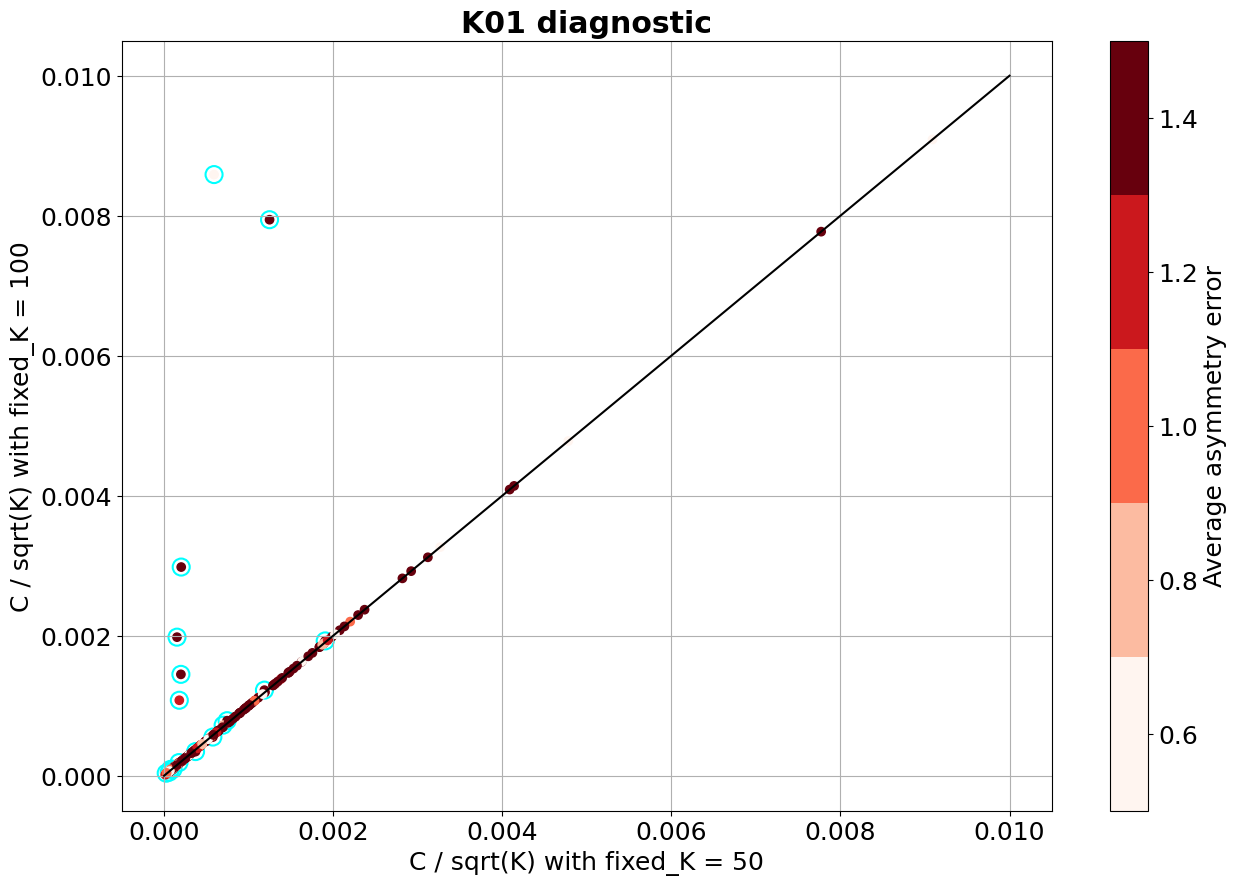

In [11]:
plt.title('K01 diagnostic', weight='bold')
msk_k01_upper = (abs(dk01.C_sqrtK_K01 - dk01_withKsetto100.C_sqrtK_K01) > 1e-5)
plt.scatter(dk01.where(msk_k01_upper).C_sqrtK_K01, dk01_withKsetto100.where(msk_k01_upper).C_sqrtK_K01, s=150, facecolors='none', edgecolors='cyan', linewidths=1.5)
plt.scatter(dk01.C_sqrtK_K01, dk01_withKsetto100.C_sqrtK_K01, c=dk01.asym_avg_err, vmin=0.5, vmax=1.5, cmap=plt.get_cmap('Reds', 5))
plt.grid()
plt.plot([0, 0.01], [0, 0.01], c='k')
plt.colorbar(label='Average asymmetry error')
plt.xlabel('C / sqrt(K) with fixed_K = 50')
plt.ylabel('C / sqrt(K) with fixed_K = 100')

Text(0, 0.5, 'C / sqrt(K) with fixed_K = 10')

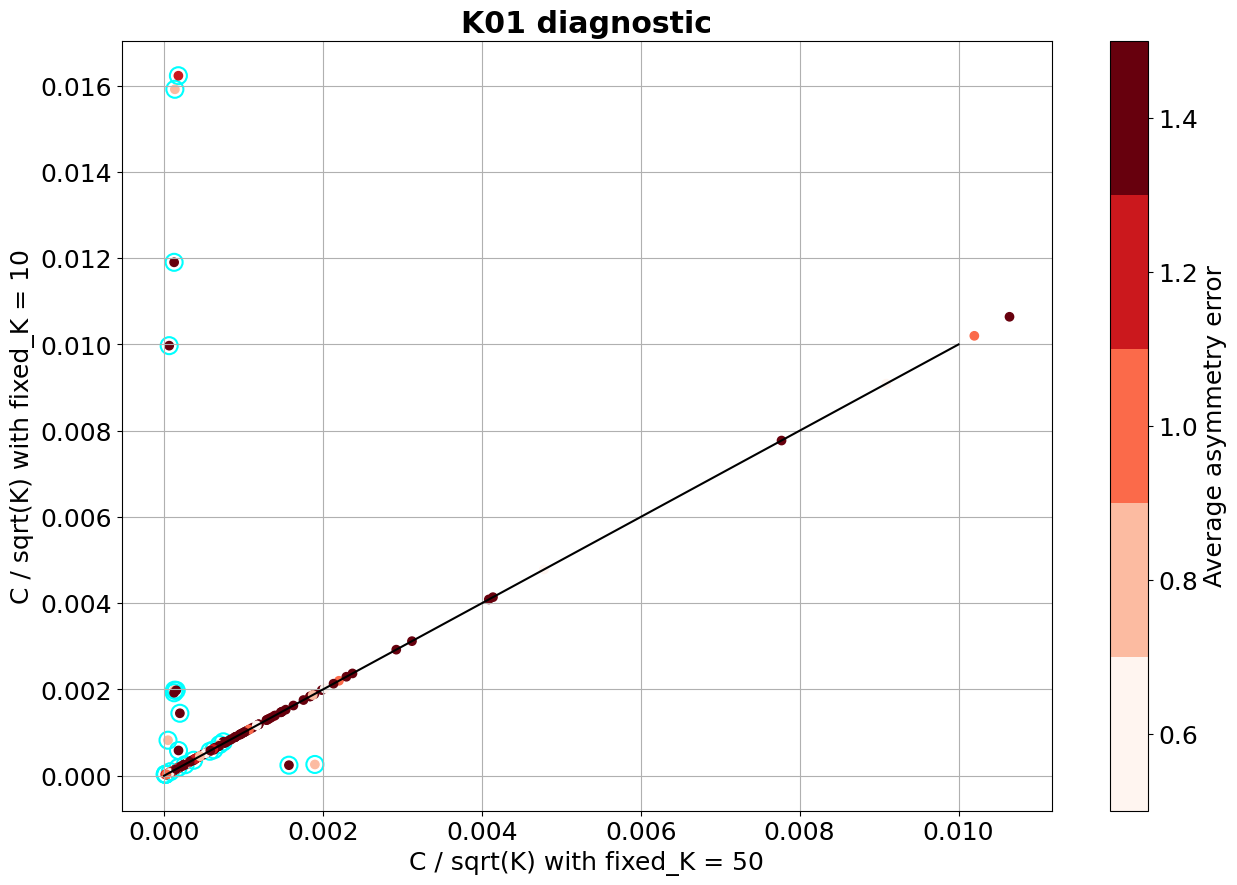

In [12]:
plt.title('K01 diagnostic', weight='bold')
msk_k01_lower = (abs(dk01.C_sqrtK_K01 - dk01_withKsetto10.C_sqrtK_K01) > 1e-5)
plt.scatter(dk01.where(msk_k01_lower).C_sqrtK_K01, dk01_withKsetto10.where(msk_k01_lower).C_sqrtK_K01, s=150, facecolors='none', edgecolors='cyan', linewidths=1.5)
plt.scatter(dk01.C_sqrtK_K01, dk01_withKsetto10.C_sqrtK_K01, c=dk01.asym_avg_err, vmin=0.5, vmax=1.5, cmap=plt.get_cmap('Reds', 5))
plt.grid()
plt.plot([0, 0.01], [0, 0.01], c='k')
plt.colorbar(label='Average asymmetry error')
plt.xlabel('C / sqrt(K) with fixed_K = 50')
plt.ylabel('C / sqrt(K) with fixed_K = 10')

For ~30-50 cases, the fitting bounds for C are reached (see commented cell below). They correspond to complicated cases.

In [13]:
# a  = dkg01_withKsetto10.where(
#     # (dkg01.lat > 0) &                           # Northern hemisphere; Remove this filter?
#     (dkg01_withKsetto10.dist2coast  > dkg01_withKsetto10.r34)             & # Distance to coast
#     (dkg01_withKsetto10.percent_outside < 10)                              & # Sufficient SAR coverage
#     (dkg01_withKsetto10.vmx > 20)                                          & # Test
#     # (dkg01_withKsetto10.C_K01 != 0.0001)                                   & # Reached the lower bound
#     # (dkg01_withKsetto10.C_K01 != 0.1)                                      & # Reached the upper bound
#     (dkg01_withKsetto10.asym_avg_err  <= 3)                                  # Asymmetry is fitted
# )
# print(len(a.where(a.C_K01 > 0.099999, drop=True).time))
# print(len(a.where(a.C_K01 < 0.00010001, drop=True).time))

# b  = dkg01_withKsetto100.where(
#     # (dkg01.lat > 0) &                           # Northern hemisphere; Remove this filter?
#     (dkg01_withKsetto100.dist2coast  > dkg01_withKsetto100.r34)             & # Distance to coast
#     (dkg01_withKsetto100.percent_outside < 10)                              & # Sufficient SAR coverage
#     (dkg01_withKsetto100.vmx > 20)                                          & # Test
#     # (dkg01_withKsetto100.C_K01 != 0.0001)                                   & # Reached the lower bound
#     # (dkg01_withKsetto100.C_K01 != 0.1)                                      & # Reached the upper bound
#     (dkg01_withKsetto100.asym_avg_err  <= 3)                                  # Asymmetry is fitted
# )
# print(len(b.where(b.C_K01 > 0.099999, drop=True).time))
# print(len(b.where(b.C_K01 < 0.00010001, drop=True).time))

#### b) K25_FIT

In [14]:
p     = '/home/arthur/results/TCsLifeMonitFromObs/winddirection/PRJCT_TCBL/00_FIT_K25/dsg_K25_withKsetto50.nc'
dkg25 = xr.open_dataset(p)
dk25  = dkg25.where(
    # (dkg25.lat > 0) &                           # Northern hemisphere; Remove this filter?
    (dkg25.dist2coast  > dkg25.r34)             & # Distance to coast
    (dkg25.percent_outside < 10)                & # Sufficient SAR coverage
    (dkg25.vmx > 20)                            & # Test
    (dkg25.C_K25 != 0.0001)                     & # Reached the lower bound
    (dkg25.C_K25 != 0.1)                        & # Reached the upper bound
    (dkg25.asym_avg_err  <= 2)                    # Asymmetry is fitted
    # (~xr.where(dkg25.non_C1 == 0, False, True)) # Ensure that I > V/r

    # ((dkg25.max_asym_K25 > 1.1) | (dkg25.max_asym_sar < 2)) # Test
    # (dkg25.phase_avg_err <= 45)                           & # Test
    # (dkg25.C_sqrtK_K25 > 1.5e-5)                          & # Test: Reached the lower bound
    # (dkg25.C_sqrtK_K25 < 1.41e-3)                         & # Test: Reached the upper bound
)
# NB: Imposing a filter on c1 or c2 doesn't seem very useful.
print(len(dkg25.time))
print(len(dk25.dropna(dim='time').time))

640
107


In [15]:
p                   = '/home/arthur/results/TCsLifeMonitFromObs/winddirection/PRJCT_TCBL/00_FIT_K25/dsg_K25_withKsetto100.nc'
dkg25_withKsetto100 = xr.open_dataset(p)
dk25_withKsetto100  = dkg25_withKsetto100.where(
    # (dkg25_withKsetto100.lat > 0) &                           # Northern hemisphere; Remove this filter?
    (dkg25_withKsetto100.dist2coast  > dkg25_withKsetto100.r34)             & # Distance to coast
    (dkg25_withKsetto100.percent_outside < 10)              & # Sufficient SAR coverage
    (dkg25_withKsetto100.vmx > 20)                          & # Test
    (dkg25_withKsetto100.C_K25 != 0.0001)                   & # Reached the lower bound
    (dkg25_withKsetto100.C_K25 != 0.1)                      & # Reached the upper bound
    (dkg25_withKsetto100.asym_avg_err  <= 2)                 # Asymmetry is fitted
    # (~xr.where(dkg25_withKsetto100.non_C1 == 0, False, True)) # Ensure that I > V/r

    # ((dkg25_withKsetto100.max_asym_K25 > 1.1) | (dkg25_withKsetto100.max_asym_sar < 2)) # Test
    # (dkg25_withKsetto100.phase_avg_err <= 45)                                         & # Test
    # (dkg25_withKsetto100.C_sqrtK_K25 > 1.5e-5)                                        & # Test: Reached the lower bound
    # (dkg25_withKsetto100.C_sqrtK_K25 < 1.41e-3)                                       & # Test: Reached the upper bound    
)
# NB: Imposing a filter on c1 or c2 doesn't seem very useful.
print(len(dkg25_withKsetto100.time))
print(len(dk25_withKsetto100.dropna(dim='time').time))

640
116


In [16]:
p                   = '/home/arthur/results/TCsLifeMonitFromObs/winddirection/PRJCT_TCBL/00_FIT_K25/dsg_K25_withKsetto10.nc'
dkg25_withKsetto10 = xr.open_dataset(p)
dk25_withKsetto10  = dkg25_withKsetto10.where(
    # (dkg25.lat > 0) &                           # Northern hemisphere; Remove this filter?
    (dkg25_withKsetto10.dist2coast  > dkg25_withKsetto10.r34)             & # Distance to coast
    (dkg25_withKsetto10.percent_outside < 10)                              & # Sufficient SAR coverage
    (dkg25_withKsetto10.vmx > 20)                                          & # Test
    (dkg25_withKsetto10.C_K25 != 0.0001)                                   & # Reached the lower bound
    (dkg25_withKsetto10.C_K25 != 0.1)                                      & # Reached the upper bound
    (dkg25_withKsetto10.asym_avg_err  <= 3)                                  # Asymmetry is fitted
    # (~xr.where(dkg25_withKsetto10.non_C1 == 0, False, True))               # Ensure that I > V/r
    
    # ((dkg25_withKsetto10.max_asym_K25 > 1.1) | (dkg25_withKsetto10.max_asym_sar <2)) # Test
    # (dkg25_withKsetto10.phase_avg_err <= 45)                 &                        # Test
    # ((dkg25_withKsetto10.storm_speed_ibt / dkg25_withKsetto10.vws_pmd) > 1)          # Test: Ratio storm_speed / wind_shead
)
print(len(dkg25_withKsetto10.time))
print(len(dkg25_withKsetto10.dropna(dim='time').time))
# NB: Imposing a filter on c1 or c2 doesn't seem very useful.
# NB: Imposing a filter on the asymmetry error or max_asym difference is not very useful (may filter 3 bad cases but also removes one good case).
# The non-C1 filter removes some "good" cases. Maybe just encircle the non-C1 cases? 

640
211


Text(0, 0.5, 'C / sqrt(K) with fixed_K = 100')

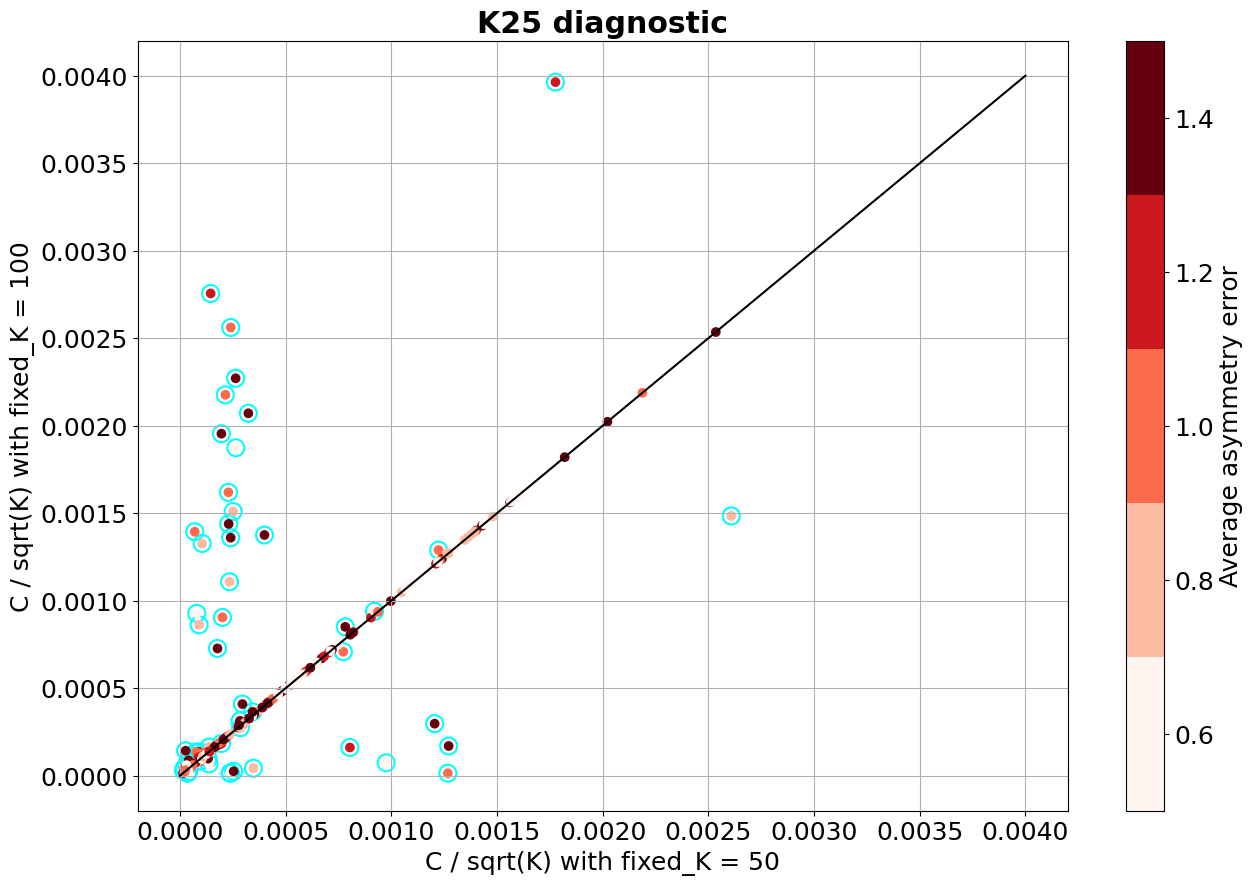

In [17]:
plt.title('K25 diagnostic', weight='bold')
msk_k25_upper = (abs(dk25.C_sqrtK_K25 - dk25_withKsetto100.C_sqrtK_K25) > 1e-5)
plt.scatter(dk25.where(msk_k25_upper).C_sqrtK_K25, dk25_withKsetto100.where(msk_k25_upper).C_sqrtK_K25, s=150, facecolors='none', edgecolors='cyan', linewidths=1.5)
plt.scatter(dk25.C_sqrtK_K25, dk25_withKsetto100.C_sqrtK_K25, c=dk25.asym_avg_err, vmin=0.5, vmax=1.5, cmap=plt.get_cmap('Reds', 5))
plt.grid()
plt.plot([0, 0.004], [0, 0.004], c='k')
# plt.xlim(0, 0.003)
# plt.ylim(0, 0.003)
plt.colorbar(label='Average asymmetry error')
plt.xlabel('C / sqrt(K) with fixed_K = 50')
plt.ylabel('C / sqrt(K) with fixed_K = 100')

Text(0, 0.5, 'C / sqrt(K) with fixed_K = 100')

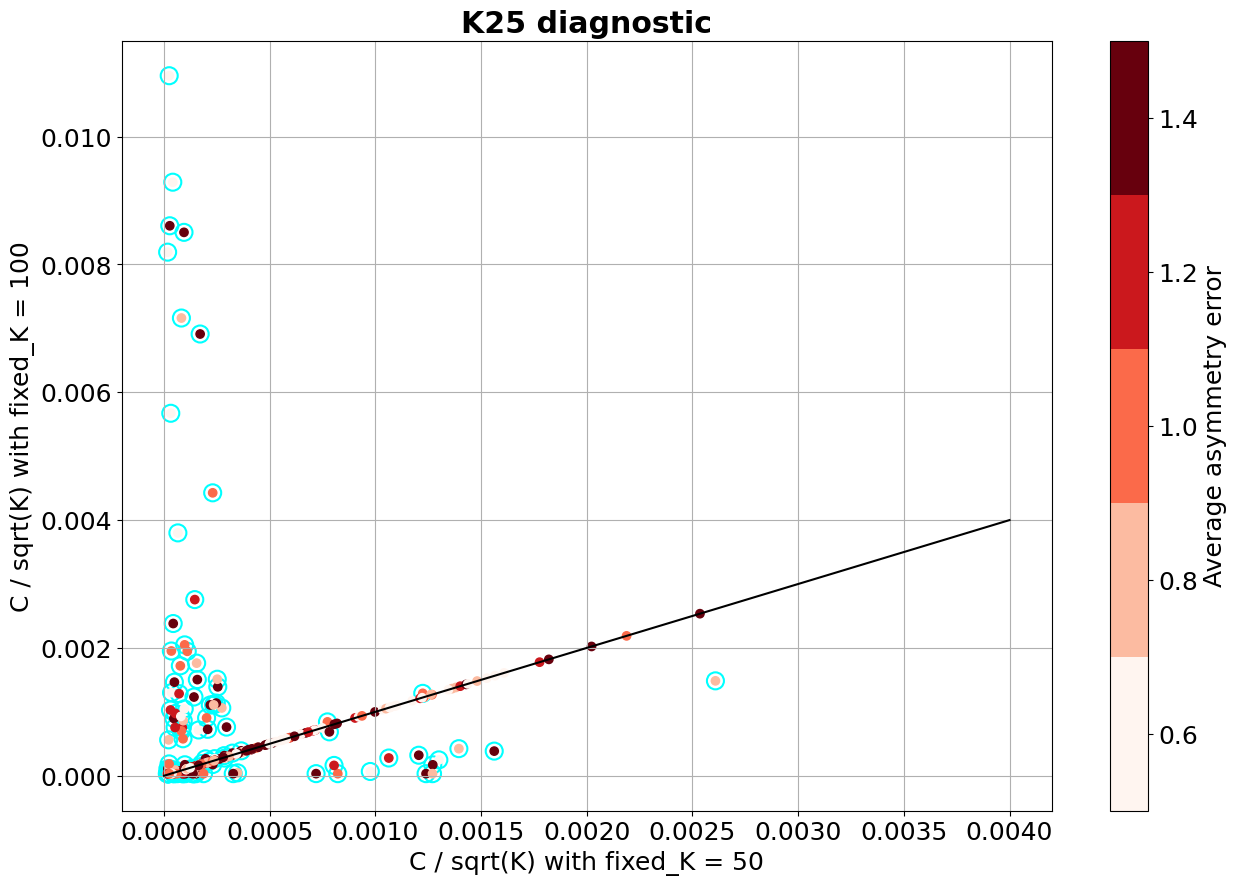

In [18]:
plt.title('K25 diagnostic', weight='bold')
msk_k25_lower = (abs(dk25.C_sqrtK_K25 - dk25_withKsetto10.C_sqrtK_K25) > 1e-5)
plt.scatter(dk25.where(msk_k25_lower).C_sqrtK_K25, dk25_withKsetto10.where(msk_k25_lower).C_sqrtK_K25, s=150, facecolors='none', edgecolors='cyan', linewidths=1.5)
plt.scatter(dk25.C_sqrtK_K25, dk25_withKsetto10.C_sqrtK_K25, c=dk25.asym_avg_err, vmin=0.5, vmax=1.5, cmap=plt.get_cmap('Reds', 5))
plt.grid()
plt.plot([0, 0.004], [0, 0.004], c='k')
# plt.xlim(0, 0.003)
# plt.ylim(0, 0.003)
plt.colorbar(label='Average asymmetry error')
plt.xlabel('C / sqrt(K) with fixed_K = 50')
plt.ylabel('C / sqrt(K) with fixed_K = 100')

The fitting bounds for C are not reached (see commented cell below).

In [19]:
# a  = dkg25_withKsetto10.where(
#     # (dkg25.lat > 0) &                           # Northern hemisphere; Remove this filter?
#     (dkg25_withKsetto10.dist2coast  > dkg25_withKsetto10.r34)             & # Distance to coast
#     (dkg25_withKsetto10.percent_outside < 10)                              & # Sufficient SAR coverage
#     (dkg25_withKsetto10.vmx > 20)                                          & # Test
#     # (dkg25_withKsetto10.C_K25 != 0.0001)                                   & # Reached the lower bound
#     # (dkg25_withKsetto10.C_K25 != 0.1)                                      & # Reached the upper bound
#     (dkg25_withKsetto10.asym_avg_err  <= 3)                                  # Asymmetry is fitted
# )
# print(len(a.where(a.C_K25 > 0.099999, drop=True).time))
# print(len(a.where(a.C_K25 < 0.00010001, drop=True).time))

# b  = dkg25_withKsetto100.where(
#     # (dkg25.lat > 0) &                           # Northern hemisphere; Remove this filter?
#     (dkg25_withKsetto100.dist2coast  > dkg25_withKsetto100.r34)             & # Distance to coast
#     (dkg25_withKsetto100.percent_outside < 10)                              & # Sufficient SAR coverage
#     (dkg25_withKsetto100.vmx > 20)                                          & # Test
#     # (dkg25_withKsetto100.C_K25 != 0.0001)                                   & # Reached the lower bound
#     # (dkg25_withKsetto100.C_K25 != 0.1)                                      & # Reached the upper bound
#     (dkg25_withKsetto100.asym_avg_err  <= 3)                                  # Asymmetry is fitted
# )
# print(len(b.where(b.C_K25 > 0.099999, drop=True).time))
# print(len(b.where(b.C_K25 < 0.00010001, drop=True).time))

#### c) K25_semiFit

In [20]:
### K25 SemiFit
p             = '/home/arthur/results/TCsLifeMonitFromObs/winddirection/PRJCT_TCBL/00_LP_KPP_K25_C1C2FIT/dsg_K25_semiFit.nc'
dkg25_semiFit = xr.open_dataset(p)
dk25_semiFit  = dkg25_semiFit.where(
    # (dkg25_semiFit.lat > 0) &                           # Northern hemisphere; Remove this filter?
    (dkg25_semiFit.dist2coast  > dkg25_semiFit.r34)     & # Distance to coast
    (dkg25_semiFit.percent_outside < 10)              & # Sufficient SAR coverage
    (dkg25_semiFit.vmx > 20)                          & # Test
    (dkg25_semiFit.asym_avg_err  <= 2)                 # Asymmetry is fitted
    # (~xr.where(dkg25_semiFit.non_C1 == 0, False, True)) # Ensure that I > V/r
    
    # (dkg25_semiFit.phase_avg_err <= 45)               & # Test
    # (dkg25_semiFit.C_sqrtK_K25 > 1.5e-5)              & # Test: Reached the lower bound
    # (dkg25_semiFit.C_sqrtK_K25 < 1.41e-3)             & # Test: Reached the upper bound
)
# NB: Imposing a filter on c1 or c2 doesn't seem very useful.
print(len(dkg25_semiFit.time))
print(len(dk25_semiFit.dropna(dim='time').time))

640
122


#### d) K01_wIA

In [21]:
p     = '/home/arthur/results/TCsLifeMonitFromObs/winddirection/PRJCT_TCBL/00_FIT_K01_wINFLOW_ANGLE/dsg_K01wIA_withKsetto50.nc'
dkg01i = xr.open_dataset(p)
dk01i  = dkg01i.where(
    # (dkg01.lat > 0) &                            # Northern hemisphere; Remove this filter?
    (dkg01i.dist2coast  > dkg01i.r34)            & # Distance to coast
    (dkg01i.percent_outside < 10)                & # Sufficient SAR coverage
    (dkg01i.vmx > 20)                            & # Test
    (dkg01i.C_K01 != 0.0001)                     & # Reached the lower bound
    (dkg01i.C_K01 != 0.1)                        & # Reached the upper bound
    (dkg01i.asym_avg_err  <= 3)                  & # Asymmetry is fitted
    (dkg01i.ratio_of_valid_scat_values > 0.9)      # Sufficient Scat coverage
    # (~xr.where(dkg01i.non_C1 == 0, False, True)) # Ensure that I > V/r
    
    # ((dkg01i.max_asym_K01 > 1.1) | (dkg01.max_asym_sar < 2)) # Test
    # (dkg01i.phase_avg_err <= 45)                 &           # Test
    # ((dkg01i.storm_speed_ibt / dkg01.vws_pmd) > 1)           # Test: Ratio storm_speed / wind_shead
)
print(len(dkg01i.time))
print(len(dk01i.dropna(dim='time').time))

349
69


In [22]:
p     = '/home/arthur/results/TCsLifeMonitFromObs/winddirection/PRJCT_TCBL/00_FIT_K01_wINFLOW_ANGLE/dsg_K01wIA_withKsetto100.nc'
dkg01i_withKsetto100 = xr.open_dataset(p)
dk01i_withKsetto100  = dkg01i_withKsetto100.where(
    # (dkg01_withKsetto100.lat > 0) &                                           # Northern hemisphere; Remove this filter?
    (dkg01i_withKsetto100.dist2coast  > dkg01i_withKsetto100.r34)             & # Distance to coast
    (dkg01i_withKsetto100.percent_outside < 10)                               & # Sufficient SAR coverage
    (dkg01i_withKsetto100.vmx > 20)                                           & # Test
    (dkg01i_withKsetto100.C_K01 != 0.0001)                                    & # Reached the lower bound
    (dkg01i_withKsetto100.C_K01 != 0.1)                                       & # Reached the upper bound
    (dkg01i_withKsetto100.asym_avg_err  <= 3)                                 & # Asymmetry is fitted
    (dkg01i_withKsetto100.ratio_of_valid_scat_values > 0.9)                     # Sufficient Scat coverage
    # (~xr.where(dkg01i_withKsetto100.non_C1 == 0, False, True))                # Ensure that I > V/r
    
    # ((dkg01i_withKsetto100.max_asym_K01 > 1.1) | (dkg01_withKsetto100.max_asym_sar < 2)) # Test
    # (dkg01i_withKsetto100.phase_avg_err <= 45)                 &                         # Test
    # ((dkg01i_withKsetto100.storm_speed_ibt / dkg01_withKsetto100.vws_pmd) > 1)           # Test: Ratio storm_speed / wind_shead
)
print(len(dkg01i_withKsetto100.time))
print(len(dk01i_withKsetto100.dropna(dim='time').time))

349
71


In [23]:
p     = '/home/arthur/results/TCsLifeMonitFromObs/winddirection/PRJCT_TCBL/00_FIT_K01_wINFLOW_ANGLE/dsg_K01wIA_withKsetto10.nc'
dkg01i_withKsetto10 = xr.open_dataset(p)
dk01i_withKsetto10  = dkg01i_withKsetto10.where(
    # (dkg01_withKsetto10.lat > 0) &                                           # Northern hemisphere; Remove this filter?
    (dkg01i_withKsetto10.dist2coast  > dkg01i_withKsetto10.r34)              & # Distance to coast
    (dkg01i_withKsetto10.percent_outside < 10)                               & # Sufficient SAR coverage
    (dkg01i_withKsetto10.vmx > 20)                                           & # Test
    (dkg01i_withKsetto10.C_K01 != 0.0001)                                    & # Reached the lower bound
    (dkg01i_withKsetto10.C_K01 != 0.1)                                       & # Reached the upper bound
    (dkg01i_withKsetto10.asym_avg_err  <= 3)                                 & # Asymmetry is fitted
    (dkg01i_withKsetto100.ratio_of_valid_scat_values > 0.9)                    # Sufficient Scat coverage
    # (~xr.where(dkg01i_withKsetto10.non_C1 == 0, False, True))                # Ensure that I > V/r
    
    # ((dkg01i_withKsetto10.max_asym_K01 > 1.1) | (dkg01_withKsetto10.max_asym_sar < 2)) # Test
    # (dkg01i_withKsetto10.phase_avg_err <= 45)                 &                        # Test
    # ((dkg01i_withKsetto10.storm_speed_ibt / dkg01_withKsetto10.vws_pmd) > 1)           # Test: Ratio storm_speed / wind_shead
)
print(len(dkg01i_withKsetto10.time))
print(len(dk01i_withKsetto10.dropna(dim='time').time))

349
68


Text(0, 0.5, 'C / sqrt(K) with fixed_K = 100')

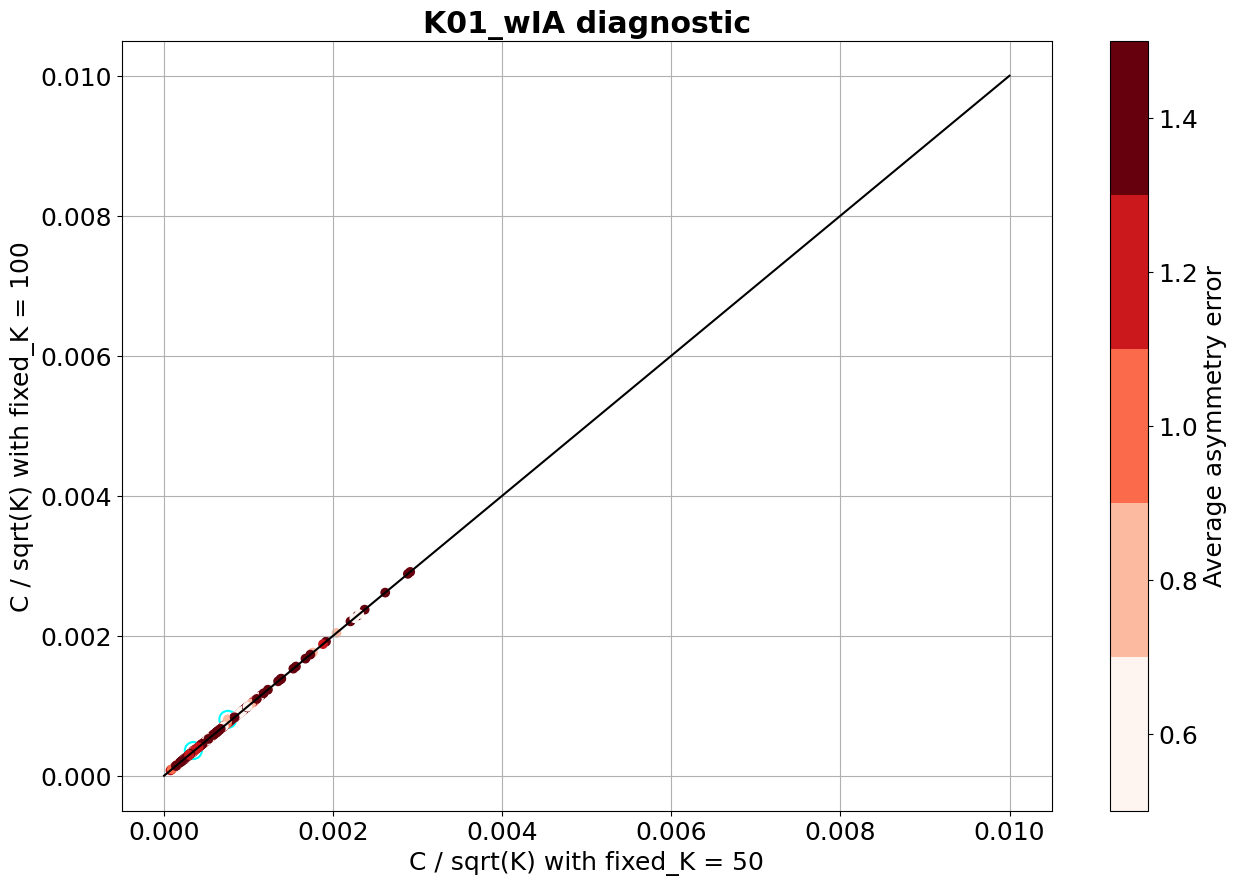

In [24]:
plt.title('K01_wIA diagnostic', weight='bold')
msk_k01i_upper = (abs(dk01i.C_sqrtK_K01 - dk01i_withKsetto100.C_sqrtK_K01) > 1e-5)
plt.scatter(dk01i.where(msk_k01i_upper).C_sqrtK_K01, dk01i_withKsetto100.where(msk_k01i_upper).C_sqrtK_K01, s=150, facecolors='none', edgecolors='cyan', linewidths=1.5)
plt.scatter(dk01i.C_sqrtK_K01, dk01i_withKsetto100.C_sqrtK_K01, c=dk01i.asym_avg_err, vmin=0.5, vmax=1.5, cmap=plt.get_cmap('Reds', 5))
plt.grid()
plt.plot([0, 0.01], [0, 0.01], c='k')
plt.colorbar(label='Average asymmetry error')
plt.xlabel('C / sqrt(K) with fixed_K = 50')
plt.ylabel('C / sqrt(K) with fixed_K = 100')

Text(0, 0.5, 'C / sqrt(K) with fixed_K = 10')

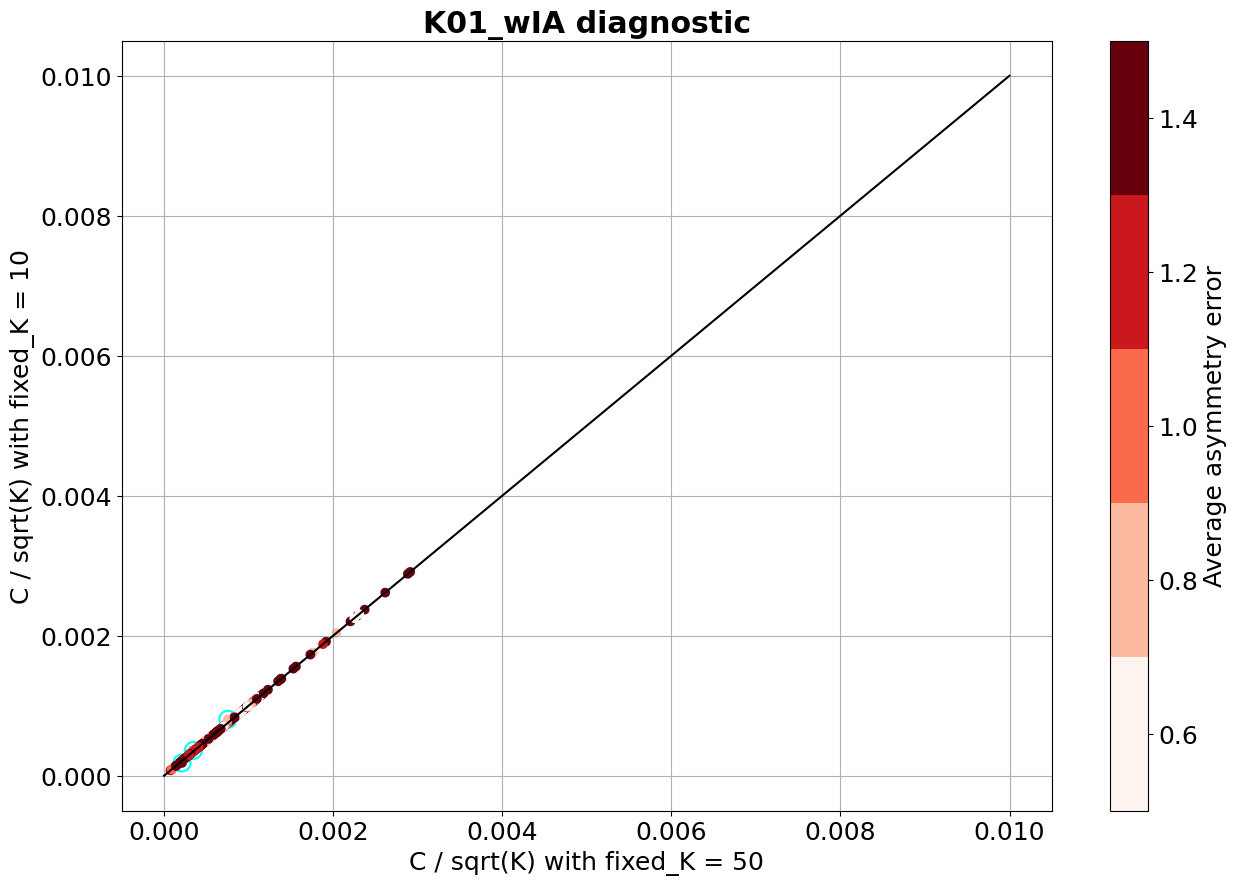

In [25]:
plt.title('K01_wIA diagnostic', weight='bold')
msk_k01i_lower = (abs(dk01i.C_sqrtK_K01 - dk01i_withKsetto10.C_sqrtK_K01) > 1e-5)
plt.scatter(dk01i.where(msk_k01i_lower).C_sqrtK_K01, dk01i_withKsetto10.where(msk_k01i_lower).C_sqrtK_K01, s=150, facecolors='none', edgecolors='cyan', linewidths=1.5)
plt.scatter(dk01i.C_sqrtK_K01, dk01i_withKsetto10.C_sqrtK_K01, c=dk01i.asym_avg_err, vmin=0.5, vmax=1.5, cmap=plt.get_cmap('Reds', 5))
plt.grid()
plt.plot([0, 0.01], [0, 0.01], c='k')
plt.colorbar(label='Average asymmetry error')
plt.xlabel('C / sqrt(K) with fixed_K = 50')
plt.ylabel('C / sqrt(K) with fixed_K = 10')

The fitting bounds for C are only reached for 2 cases (see commented cell below).

In [26]:
# a  = dkg01i_withKsetto10.where(
#     # (dkg01i.lat > 0) &                           # Northern hemisphere; Remove this filter?
#     (dkg01i_withKsetto10.dist2coast  > dkg01i_withKsetto10.r34)             & # Distance to coast
#     (dkg01i_withKsetto10.percent_outside < 10)                              & # Sufficient SAR coverage
#     (dkg01i_withKsetto10.vmx > 20)                                          & # Test
#     # (dkg01i_withKsetto10.C_K01 != 0.0001)                                 & # Reached the lower bound
#     # (dkg01i_withKsetto10.C_K01 != 0.1)                                    & # Reached the upper bound
#     (dkg01i_withKsetto10.asym_avg_err  <= 3)                                & # Asymmetry is fitted
#     (dkg01i_withKsetto100.ratio_of_valid_scat_values > 0.9)                   # Sufficient Scat coverage
# )
# print(len(a.where(a.C_K01 > 0.099999, drop=True).time))
# print(len(a.where(a.C_K01 < 0.00010001, drop=True).time))

# b  = dkg01i_withKsetto100.where(
#     # (dkg01i.lat > 0) &                           # Northern hemisphere; Remove this filter?
#     (dkg01i_withKsetto100.dist2coast  > dkg01i_withKsetto100.r34)            & # Distance to coast
#     (dkg01i_withKsetto100.percent_outside < 10)                              & # Sufficient SAR coverage
#     (dkg01i_withKsetto100.vmx > 20)                                          & # Test
#     # (dkg01i_withKsetto100.C_K01 != 0.0001)                                 & # Reached the lower bound
#     # (dkg01i_withKsetto100.C_K01 != 0.1)                                    & # Reached the upper bound
#     (dkg01i_withKsetto100.asym_avg_err  <= 3)                                & # Asymmetry is fitted
#     (dkg01i_withKsetto100.ratio_of_valid_scat_values > 0.9)                    # Sufficient Scat coverage
# )
# print(len(b.where(b.C_K01 > 0.099999, drop=True).time))
# print(len(b.where(b.C_K01 < 0.00010001, drop=True).time))

#### e) K25_wIA

In [27]:
p     = '/home/arthur/results/TCsLifeMonitFromObs/winddirection/PRJCT_TCBL/00_FIT_K25_wINFLOW_ANGLE/dsg_K25wIA_withKsetto50.nc'
dkg25i = xr.open_dataset(p)
dk25i  = dkg25i.where(
    # (dkg25.lat > 0) &                            # Northern hemisphere; Remove this filter?
    (dkg25i.dist2coast  > dkg25i.r34)            & # Distance to coast
    (dkg25i.percent_outside < 10)                & # Sufficient SAR coverage
    (dkg25i.vmx > 20)                            & # Test
    (dkg25i.C_K25 != 0.0001)                     & # Reached the lower bound
    (dkg25i.C_K25 != 0.1)                        & # Reached the upper bound
    (dkg25i.asym_avg_err  <= 3)                  & # Asymmetry is fitted
    (dkg25i.ratio_of_valid_scat_values > 0.9)      # Sufficient Scat coverage
    # (~xr.where(dkg25i.non_C1 == 0, False, True)) # Ensure that I > V/r
    
    # ((dkg25i.max_asym_K25 > 1.1) | (dkg25.max_asym_sar < 2)) # Test
    # (dkg25i.phase_avg_err <= 45)                 &           # Test
    # ((dkg25i.storm_speed_ibt / dkg25.vws_pmd) > 1)           # Test: Ratio storm_speed / wind_shead
)
print(len(dkg25i.time))
print(len(dk25i.dropna(dim='time').time))

316
80


In [28]:
p     = '/home/arthur/results/TCsLifeMonitFromObs/winddirection/PRJCT_TCBL/00_FIT_K25_wINFLOW_ANGLE/dsg_K25wIA_withKsetto100.nc'
dkg25i_withKsetto100 = xr.open_dataset(p)
dk25i_withKsetto100  = dkg25i_withKsetto100.where(
    # (dkg25_withKsetto100.lat > 0) &                                           # Northern hemisphere; Remove this filter?
    (dkg25i_withKsetto100.dist2coast  > dkg25i_withKsetto100.r34)             & # Distance to coast
    (dkg25i_withKsetto100.percent_outside < 10)                               & # Sufficient SAR coverage
    (dkg25i_withKsetto100.vmx > 20)                                           & # Test
    (dkg25i_withKsetto100.C_K25 != 0.0001)                                    & # Reached the lower bound
    (dkg25i_withKsetto100.C_K25 != 0.1)                                       & # Reached the upper bound
    (dkg25i_withKsetto100.asym_avg_err  <= 3)                                 & # Asymmetry is fitted
    (dkg25i_withKsetto100.ratio_of_valid_scat_values > 0.9)                     # Sufficient Scat coverage
    # (~xr.where(dkg25i_withKsetto100.non_C1 == 0, False, True))                # Ensure that I > V/r
    
    # ((dkg25i_withKsetto100.max_asym_K25 > 1.1) | (dkg25_withKsetto100.max_asym_sar < 2)) # Test
    # (dkg25i_withKsetto100.phase_avg_err <= 45)                 &                         # Test
    # ((dkg25i_withKsetto100.storm_speed_ibt / dkg25_withKsetto100.vws_pmd) > 1)           # Test: Ratio storm_speed / wind_shead
)
print(len(dkg25i_withKsetto100.time))
print(len(dk25i_withKsetto100.dropna(dim='time').time))

316
78


In [29]:
p     = '/home/arthur/results/TCsLifeMonitFromObs/winddirection/PRJCT_TCBL/00_FIT_K25_wINFLOW_ANGLE/dsg_K25wIA_withKsetto10.nc'
dkg25i_withKsetto10 = xr.open_dataset(p)
dk25i_withKsetto10  = dkg25i_withKsetto10.where(
    # (dkg25_withKsetto10.lat > 0) &                                           # Northern hemisphere; Remove this filter?
    (dkg25i_withKsetto10.dist2coast  > dkg25i_withKsetto10.r34)              & # Distance to coast
    (dkg25i_withKsetto10.percent_outside < 10)                               & # Sufficient SAR coverage
    (dkg25i_withKsetto10.vmx > 20)                                           & # Test
    (dkg25i_withKsetto10.C_K25 != 0.0001)                                    & # Reached the lower bound
    (dkg25i_withKsetto10.C_K25 != 0.1)                                       & # Reached the upper bound
    (dkg25i_withKsetto10.asym_avg_err  <= 3)                                 & # Asymmetry is fitted
    (dkg25i_withKsetto100.ratio_of_valid_scat_values > 0.9)                    # Sufficient Scat coverage
    # (~xr.where(dkg25i_withKsetto10.non_C1 == 0, False, True))                # Ensure that I > V/r
    
    # ((dkg25i_withKsetto10.max_asym_K25 > 1.1) | (dkg25_withKsetto10.max_asym_sar < 2)) # Test
    # (dkg25i_withKsetto10.phase_avg_err <= 45)                 &                        # Test
    # ((dkg25i_withKsetto10.storm_speed_ibt / dkg25_withKsetto10.vws_pmd) > 1)           # Test: Ratio storm_speed / wind_shead
)
print(len(dkg25i_withKsetto10.time))
print(len(dk25i_withKsetto10.dropna(dim='time').time))

316
80


Text(0, 0.5, 'C / sqrt(K) with fixed_K = 100')

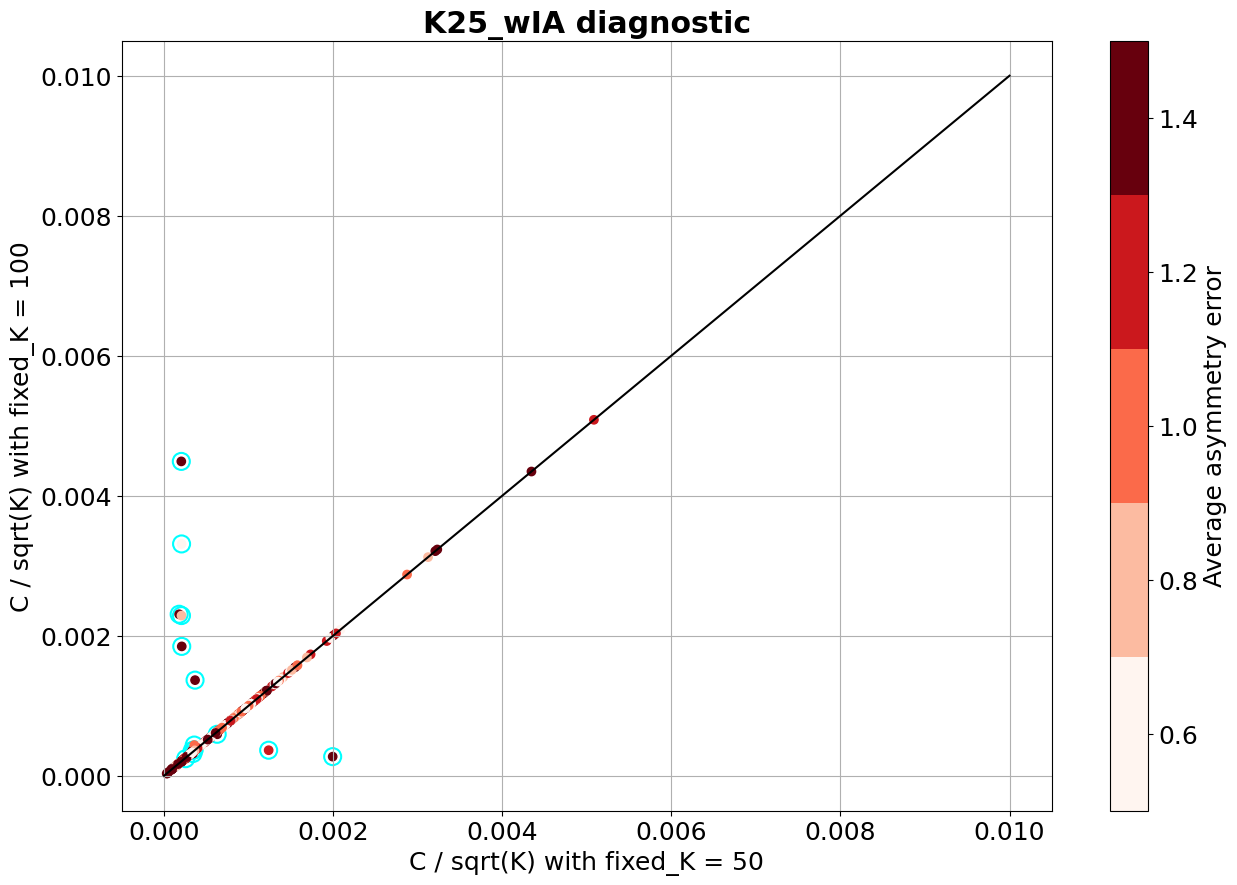

In [30]:
plt.title('K25_wIA diagnostic', weight='bold')
msk_k25i_upper = (abs(dk25i.C_sqrtK_K25 - dk25i_withKsetto100.C_sqrtK_K25) > 1e-5)
plt.scatter(dk25i.where(msk_k25i_upper).C_sqrtK_K25, dk25i_withKsetto100.where(msk_k25i_upper).C_sqrtK_K25, s=150, facecolors='none', edgecolors='cyan', linewidths=1.5)
plt.scatter(dk25i.C_sqrtK_K25, dk25i_withKsetto100.C_sqrtK_K25, c=dk25i.asym_avg_err, vmin=0.5, vmax=1.5, cmap=plt.get_cmap('Reds', 5))
plt.grid()
plt.plot([0, 0.01], [0, 0.01], c='k')
plt.colorbar(label='Average asymmetry error')
plt.xlabel('C / sqrt(K) with fixed_K = 50')
plt.ylabel('C / sqrt(K) with fixed_K = 100')

Text(0, 0.5, 'C / sqrt(K) with fixed_K = 10')

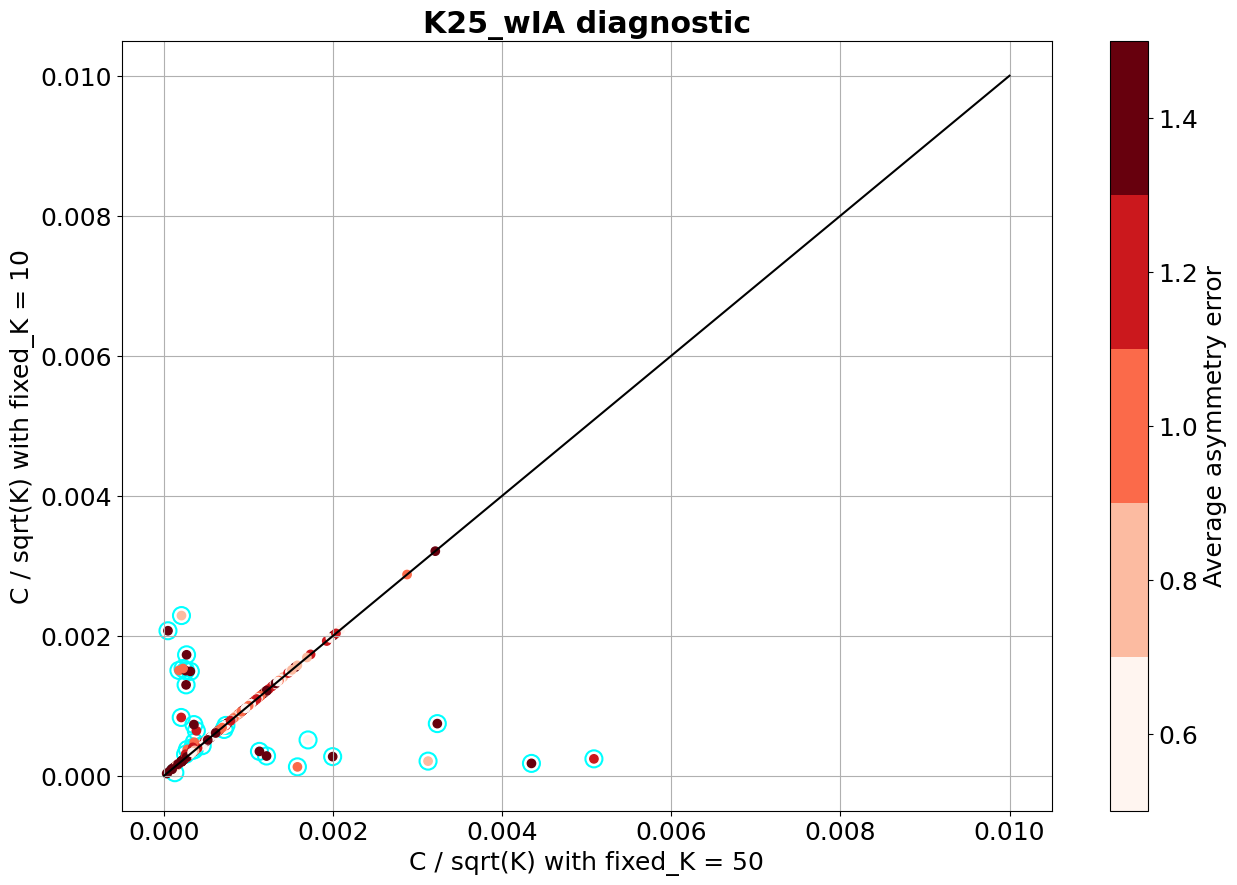

In [31]:
plt.title('K25_wIA diagnostic', weight='bold')
msk_k25i_lower = (abs(dk25i.C_sqrtK_K25 - dk25i_withKsetto10.C_sqrtK_K25) > 1e-5)
plt.scatter(dk25i.where(msk_k25i_lower).C_sqrtK_K25, dk25i_withKsetto10.where(msk_k25i_lower).C_sqrtK_K25, s=150, facecolors='none', edgecolors='cyan', linewidths=1.5)
plt.scatter(dk25i.C_sqrtK_K25, dk25i_withKsetto10.C_sqrtK_K25, c=dk25i.asym_avg_err, vmin=0.5, vmax=1.5, cmap=plt.get_cmap('Reds', 5))
plt.grid()
plt.plot([0, 0.01], [0, 0.01], c='k')
plt.colorbar(label='Average asymmetry error')
plt.xlabel('C / sqrt(K) with fixed_K = 50')
plt.ylabel('C / sqrt(K) with fixed_K = 10')

The fitting bounds for C are only reached for 1 case (see commented cell below).

In [32]:
# a  = dkg25i_withKsetto10.where(
#     # (dkg25i.lat > 0) &                           # Northern hemisphere; Remove this filter?
#     (dkg25i_withKsetto10.dist2coast  > dkg25i_withKsetto10.r34)             & # Distance to coast
#     (dkg25i_withKsetto10.percent_outside < 10)                              & # Sufficient SAR coverage
#     (dkg25i_withKsetto10.vmx > 20)                                          & # Test
#     # (dkg25i_withKsetto10.C_K25 != 0.0001)                                 & # Reached the lower bound
#     # (dkg25i_withKsetto10.C_K25 != 0.1)                                    & # Reached the upper bound
#     (dkg25i_withKsetto10.asym_avg_err  <= 3)                                & # Asymmetry is fitted
#     (dkg25i_withKsetto100.ratio_of_valid_scat_values > 0.9)                   # Sufficient Scat coverage
# )
# print(len(a.where(a.C_K25 > 0.099999, drop=True).time))
# print(len(a.where(a.C_K25 < 0.00010001, drop=True).time))

# b  = dkg25i_withKsetto100.where(
#     # (dkg25i.lat > 0) &                           # Northern hemisphere; Remove this filter?
#     (dkg25i_withKsetto100.dist2coast  > dkg25i_withKsetto100.r34)            & # Distance to coast
#     (dkg25i_withKsetto100.percent_outside < 10)                              & # Sufficient SAR coverage
#     (dkg25i_withKsetto100.vmx > 20)                                          & # Test
#     # (dkg25i_withKsetto100.C_K25 != 0.0001)                                 & # Reached the lower bound
#     # (dkg25i_withKsetto100.C_K25 != 0.1)                                    & # Reached the upper bound
#     (dkg25i_withKsetto100.asym_avg_err  <= 3)                                & # Asymmetry is fitted
#     (dkg25i_withKsetto100.ratio_of_valid_scat_values > 0.9)                    # Sufficient Scat coverage
# )
# print(len(b.where(b.C_K25 > 0.099999, drop=True).time))
# print(len(b.where(b.C_K25 < 0.00010001, drop=True).time))

#### f) Clean the datasets

In [33]:
### FILTER BOTH DATASETS
# TO ENSURE THAT FIXED_K HAS NO IMPACT
dk01_clean  = dk01.where(~msk_k01_upper & ~msk_k01_lower)
dk25_clean  = dk25.where(~msk_k25_upper & ~msk_k25_lower)
dk01i_clean = dk01i.where(~msk_k01i_upper & ~msk_k01i_lower)
dk25i_clean = dk25i.where(~msk_k25i_upper & ~msk_k25i_lower)

# # TO DROP DUPLICATES FOR MULTIPLE SCAT COLLOCATIONS
# dk01i_clean = dk01i_clean.where(~dk01i_clean.indexes['time'].duplicated()).dropna(dim='time')
# dk25i_clean = dk25i_clean.where(~dk25i_clean.indexes['time'].duplicated()).dropna(dim='time')
dk01i_clean =  dk01i_clean.drop_duplicates(dim='time', keep='first')
dk25i_clean =  dk25i_clean.drop_duplicates(dim='time', keep='first')

### 1) Diagnose wind speeds

In [7]:
# r_star
r_star = np.linspace(0, 16, 16 * 8 + 1)

# # Fit Holland
# rs            = np.linspace(1000, 5e5, 500)

In [10]:
### Initialize
listOfWspds_dsp       = [] # SAR
# K01 param
listOfWspds_dsk01_prm = [] # K01 param
wspd_diffs_k01p       = [] # Wind speed diffs,                       
wspd_res_k01p         = [] # Wind speed relative errors,             
# aamp_diffs_k01p       = [] # Asymmetry amplitude diffs,              
# aamp_res_k01p         = [] # Asymmetry amplitude relative errors,    
# aphs_diffs_k01p       = [] # Asymmetry phase of max. diffs,          
# K01 fit
listOfWspds_dsk01_fit = [] # K01 fit
wspd_diffs_k01f       = [] # Wind speed diffs,                       
wspd_res_k01f         = [] # Wind speed relative errors,             
# aamp_diffs_k01f       = [] # Asymmetry amplitude diffs,              
# aamp_res_k01f         = [] # Asymmetry amplitude relative errors,    
# aphs_diffs_k01f       = [] # Asymmetry phase of max. diffs,          

for path in tqdm(list_of_PRM_paths):
    dsk01_prm = xr.open_dataset(PTHS['K01_PRM_dir'] + os.path.basename(path)).sel(z=10, theta=slice(0, 359))
    # dsk25_prm = xr.open_dataset(PTHS['K25_PRM_dir'] + os.path.basename(path)).sel(z=10, theta=slice(0, 359))
    ds        = dsg_filtered.where(dsg_filtered.file_tcva == dsk01_prm.file_tcva.item(), drop=True).isel(time=0)
    dsp       = xr.open_dataset(PTHS['sar_dir'] + dsk01_prm.file_tcva.item()).isel(time=0)

    # Interpolate on r_star
    # dss, dk01p, dk01f = dsp.copy(deep=True), dsk01_prm.copy(deep=True), dsk01_fit.copy(deep=True)
    dss, dk01p = dsp.copy(deep=True), dsk01_prm.copy(deep=True)
    dss['rad']        = dss['rad'] / float(ds.rmx)
    dk01p['rad']      = dk01p['rad'] / float(ds.rmx)
    # dk01f['rad']      = dk01f['rad'] / float(ds.rmx)
    wspd_diff_k01p    = np.subtract(np.array(dss.wind_speed.transpose().interp(rad=r_star)), np.array(dk01p.wind_speed.interp(rad=r_star)))
    wspd_re_k01p      = np.divide(wspd_diff_k01p, np.array(dss.wind_speed.transpose().interp(rad=r_star)))
    # wspd_diff_k01f    = np.subtract(np.array(dss.wind_speed.transpose().interp(rad=r_star)), np.array(dk01f.wind_speed.interp(rad=r_star)))
    # wspd_re_k01f      = np.divide(wspd_diff_k01f, np.array(dss.wind_speed.transpose().interp(rad=r_star)))

    # ### Asymmetries
    # ## K01 param, r_star
    # aks_k01p         = []
    # pks_k01p         = []
    # # Iterate over all radii
    # for rad in r_star[1:]: # Iterate only in the valid range to optimize time
    #     try:
    #         ak, phi, _  = get_wn1(np.deg2rad(dk01p.theta), dk01p.wind_speed.sel(rad=rad, method='nearest'), float(ds.vmx) / 3, float(ds.vmx))
    #     except RuntimeError:
    #         ak = phi = np.nan
    #     aks_k01p.append(ak)
    #     pks_k01p.append(phi)
    # ## K01 fit, r_star
    # aks_k01f = []
    # pks_k01f = []
    # # Iterate over all radii
    # for rad in r_star[1:]: # Iterate only in the valid range to optimize time
    #     try:
    #         ak, phi, _  = get_wn1(np.deg2rad(dk01f.theta), dk01f.wind_speed.sel(rad=rad, method='nearest'), float(ds.vmx) / 3, float(ds.vmx))
    #     except RuntimeError:
    #         ak = phi = np.nan
    #     aks_k01f.append(ak)
    #     pks_k01f.append(phi)
    # ## SAR, r_star
    # # Initialize
    # LWS = [] # To save the Holland wind speeds
    # # ERR = [] # To compute RMSE
    # ACN = [] # Amplitude of cosine
    # PHS = [] # Phase of cosine
    # # VTS = [] # Nb of valid thetas
    
    # # Fit Holland for each theta
    # for th in th_steps:
    #     ds_slice          = dsp.sel(theta=slice(th, th + th_delta))
    #     wsm               = ds_slice.wind_speed.mean(dim='theta', skipna=True)
    #     r_crop, spdm_crop = initialize_radius(np.array(wsm))
    
    #     try:
    #         # Holland
    #         popt, pcov = curve_fit(
    #             lambda r, B, Vmin, Rmax, Vmax: holland_profile(r, abs(float(ds.lat)), B, Vmin, Rmax, Vmax), 
    #             np.array(r_crop), 
    #             np.array(spdm_crop), 
    #             p0=[1.8, 5, 20 * 1000, 40], 
    #             bounds=(
    #                 tuple([BDS_HOL[e][0] for e in BDS_HOL.keys()]), # NB: lat is fixed
    #                 tuple([BDS_HOL[e][1] for e in BDS_HOL.keys()])
    #             ) 
    #         ) 
    #         B_hol, vmn_hol, rmx_hol, vmx_hol = popt
            
    #     except RuntimeError:
    #         B_hol = vmn_hol = rmx_hol = vmx_hol = np.nan
        
    #     # Append
    #     LWS.append(holland_profile(rs, abs(float(ds.lat)), B_hol, vmn_hol, rmx_hol, vmx_hol))
    
    # # Create dataset with Holland for each theta
    # dsh = xr.Dataset(
    #     data_vars={
    #         'ws':        (('th', 'rad'), LWS),
    #     },
    #     coords={
    #         'th': th_steps,
    #         'rad': rs,
    #     }
    # )
    
    # # Interpolate on r*
    # dsh['rad']     = dsh['rad'] / float(ds.rmx)
    # dsh.interp(rad=r_star)
    
    # # Compute asymmetries
    # for rad in r_star[1:]:
    #     # Amplitude of cosine
    #     if np.count_nonzero(np.isnan(dsh.sel(rad=rad, method='nearest').ws)) == 0:
    #         acn, phi, c = get_wn1(np.deg2rad(dsh.sel(rad=rad, method='nearest').th), dsh.sel(rad=rad, method='nearest').ws, float(ds.vmx) / 3, float(ds.vmx))
    #     else:
    #         acn = phi = c = np.nan
    #     ACN.append(acn)
    #     PHS.append(phi)
    #     # # Error
    #     # error         = float(rmse(dsh.sel(rad=rad, method='nearest').ws, wn1(np.deg2rad(dsh.th), acn, phi, c))) 
    #     # ERR.append(error)
    #     # # Valid thetas
    #     # VTS.append(len(dsp.sel(rad=rad, method='nearest').dropna(subset=['wind_speed'], dim='theta').theta))

    # ## Differences and relative errors
    # # K01 param
    # aamp_diff_k01p = np.subtract(np.array(ACN), np.array(aks))
    # aamp_re_k01p   = np.divide(aamp_diff_k01p, np.array(ACN))
    # aphs_diff_k01p = np.minimum(abs(np.subtract(np.array(PHS), np.array(pks))), 360 - abs(np.subtract(np.array(PHS), np.array(pks))))
    # # aphs_diff_k01p = np.subtract(np.array(PHS), np.array(pks))
    # # aphs_re_k01p   = np.divide(aamp_diff_k01p, np.array(PHS))
    # # K01 fit
    # aamp_diff_k01f = np.subtract(np.array(ACN), np.array(aks_k01f))
    # aamp_re_k01f   = np.divide(aamp_diff_k01f, np.array(ACN))
    # aphs_diff_k01f = np.minimum(abs(np.subtract(np.array(PHS), np.array(pks_k01f))), 360 - abs(np.subtract(np.array(PHS), np.array(pks_k01f))))
    # # aphs_diff_k01f = np.subtract(np.array(PHS), np.array(pks_k01f))
    # # aphs_re_k01f   = np.divide(aamp_diff_k01f, np.array(PHS))

    ### Append
    # SAR
    listOfWspds_dsp.append(np.array(dsp.wind_speed.transpose()).flatten())
    # K01 param
    listOfWspds_dsk01_prm.append(np.array(dsk01_prm.wind_speed).flatten())
    wspd_diffs_k01p.append(wspd_diff_k01p)
    wspd_res_k01p.append(wspd_re_k01p)
    
    # aamp_diffs_k01p.append(aamp_diff_k01p)
    # aamp_res_k01p.append(aamp_re_k01p)
    # aphs_diffs_k01p.append(aphs_diff_k01p)
    # # aphs_res_k01p.append(aphs_re_k01p)
    
    # # K01 fit
    # listOfWspds_dsk01_fit.append(np.array(dsk01_fit.wind_speed).flatten())
    # wspd_diffs_k01f.append(wspd_diff_k01f)
    # wspd_res_k01f.append(wspd_re_k01f)
    
    # aamp_diffs_k01f.append(aamp_diff_k01f)
    # aamp_res_k01f.append(aamp_re_k01f)
    # aphs_diffs_k01f.append(aphs_diff_k01f)
    # # aphs_res_k01f.append(aphs_re_k01f)

    # Close
    dsp.close()
    dsk01_prm.close()
    dss.close()
    # dsk25_prm.close()

  0%|          | 0/175 [00:00<?, ?it/s]

In [11]:
wspds_dsp       = np.concatenate(listOfWspds_dsp)
wspds_dsk01_prm = np.concatenate(listOfWspds_dsk01_prm)
# wspds_dsk01_fit = np.concatenate(listOfWspds_dsk01_fit)

#### a) KXX_PRM